In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image # Pillow library -> PIL
from IPython import display
import time
from joblib import Parallel, delayed, cpu_count

import pandas as pd

### Global function:

In [2]:
# Define a global function

def run_simulation(c_value, N):
    """
    """
    # Define the domain and resolution
    Lx = Ly = 1.0
    Nx = Ny = N
    
    # Spatial steps (index i)
    delta_x = delta_y = 2*Lx/Nx
    
    # Diffusion coeficient
    c = c_value
    
    # Time step
    t_sim = 0.1
    n_t   = 100
    delta_t = t_sim/n_t

    # 2D axes
    x = np.linspace(-Lx, +Lx, Nx)
    y = np.linspace(-Ly, +Ly, Ny)
    
    # Meshgrid
    x_2d, y_2d = np.meshgrid(x, y)

    # Empty array
    u = np.zeros((Nx, Ny))
    
    #print(u.shape)
    # Add 1's inside the central box -> square pulse
    u[Nx //2 - Nx // 6:Nx//2 + Nx // 6, Ny //2 - Ny // 6:Ny//2 + Ny // 6] = 1.

    # Define alpha
    alpha = c*delta_t/(2*delta_x**2)
    #return u

    # Flatten the grid
    N = Nx*Ny

    # Diagonal elements
    diag_0 = (1 + 4*alpha)*np.ones(N)
    diag_s = -alpha*np.ones(N - 1)
    diag_u = -alpha*np.ones(N - Nx)
    #print(diag_s.shape)
    
    # For the A matrix (LHS)
    a_matrix = np.diag(diag_0)
    a_matrix += np.diag(diag_s, k = 1)
    a_matrix += np.diag(diag_s, k = -1)
    a_matrix += np.diag(diag_u, k = Nx)
    a_matrix += np.diag(diag_u, k = -Nx)

    # Non-periodic boundary conditions
    for i in range(1, Ny):
        # Last element of previous row and first element of current row = 0
        a_matrix[i * Nx - 1, i * Nx] = 0
        a_matrix[i * Nx, i * Nx - 1] = 0

    # Diagonal elements
    diag_0 = (1 - 4*alpha)*np.ones(N)
    diag_s = alpha*np.ones(N - 1)
    diag_u = alpha*np.ones(N - Nx)
    #print(diag_s.shape)
    
    # For the B matrix RLHS)
    
    b_matrix = np.diag(diag_0)
    b_matrix += np.diag(diag_s, k = 1)
    b_matrix += np.diag(diag_s, k = -1)
    b_matrix += np.diag(diag_u, k = Nx)
    b_matrix += np.diag(diag_u, k = -Nx)
    
    #print(b_matrix)
    for i in range(1, Ny):
        b_matrix[i * Nx - 1, i * Nx] = 0
        b_matrix[i * Nx, i * Nx - 1] = 0
    
    # Define b using the explicit step
    b = b_matrix @ u.flatten()
    
    # Flattened solution
    u_new = np.linalg.solve(a_matrix, b)
    
    # Reshape solution
    u_new = u_new.reshape((Nx, Ny))

    #return u_new
    # Empty 3D array (t,y,x)
    
    macro_arr = np.zeros((n_t, Ny, Nx))
    
    macro_arr[0, :, : ] = u

    # Make a copy of the initial condition
    u_new = u.copy()
    
    # For loop in time
    for n in range(n_t - 1):
        #print(n)
    
        # Define b using the explicit step - RHS
        b = b_matrix @ u_new.flatten()
        
        # Flattened solution - LHS
        u_new = np.linalg.solve(a_matrix, b)
        
        #print(u_new.shape)
        
        # Reshape solution
        u_new = u_new.reshape((Nx, Ny))
        
        #print(u_new.shape)
    
        macro_arr[n + 1, :, :] = u_new.copy()
    
    return x_2d, y_2d, macro_arr

In [3]:
#x_2d, y_2d, a_test = run_simulation(1., 40)

#print(len(a_test))

In [4]:
# for k in range(len(a_test)):
    
#     # 2D projection
#     plt.figure(figsize=(4,3))
#     z_0 = plt.pcolor(x_2d, y_2d, a_test[k, :, : ], cmap = "plasma", clim = (0,1))

#     plt.colorbar(z_0, shrink=0.6, pad=0.1)

#     plt.xlim(-1., +1.)
#     plt.ylim(-1., +1.)

#     plt.show()

### Execution lines:

In [5]:
if __name__ == "__main__":

    # List of c values
    c_vals = list(np.linspace(0.1, 1.5, 8))
    
    # Resolution
    n_res = 40

    # Number of CPU cores
    n_cpu = [1, 2, 4, 8]

    # Empty list to store times
    elapsed_times = []

    # Call joblib'
    for k in range(len(n_cpu)):
        #print(n_cpu[k])
        
        # Start time stamp
        st_time = time.time()        
        
        Parallel(n_jobs = n_cpu[k])(delayed(run_simulation)(c_vals[i], n_res) for i in range(len(c_vals)))
        
        # End time stamp
        en_time = time.time()  

        # Elapsed time
        elapsed = en_time - st_time

        # Append elapsed time values
        elapsed_times.append(elapsed)

    # Print the time
    print(elapsed_times)



[60.158092975616455, 29.77104687690735, 13.645395994186401, 6.30972695350647]


### Computational scaling:

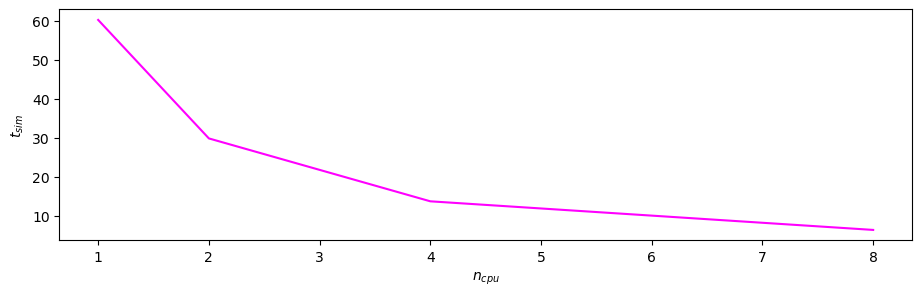

In [6]:
plt.figure(figsize=(11,3))

plt.plot(n_cpu, elapsed_times, color = "magenta")

plt.xlabel(r"$n_{cpu}$")

plt.ylabel(r"$t_{sim}$")

plt.show()